In [6]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [4]:
def load_images_from_folder(folder, size=(640, 480)):
    images = []
    for filename in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
    return images

In [20]:
import numpy as np

def add_noise_and_modify(image):
    height, width, channels = image.shape
    new_image = np.zeros_like(image)
    
    def process_block(block):
        avg_val = np.mean(block)
        modifier = 0.2 * avg_val
        block = block.astype(np.float32)
        block = np.where(np.random.rand(*block.shape) > 0.5, block + modifier, block - modifier)
        return block.astype(np.uint8)

    for i in range(0, height, 32):
        for j in range(0, width, 32):
            block = image[i:i+32, j:j+32]
            if block.shape[0] != 32 or block.shape[1] != 32:
                padded_block = np.zeros((32, 32, channels), dtype=image.dtype)
                padded_block[:block.shape[0], :block.shape[1]] = block
                processed_block = process_block(padded_block)
                new_image[i:i+32, j:j+32] = processed_block[:block.shape[0], :block.shape[1]]
            else:
                new_image[i:i+32, j:j+32] = process_block(block)
    
    return new_image




In [7]:
def save_images(images, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for idx, img in enumerate(tqdm(images)):
        cv2.imwrite(os.path.join(folder, f"image_{idx}.png"), img)


100%|██████████| 44/44 [00:00<00:00, 478.20it/s]


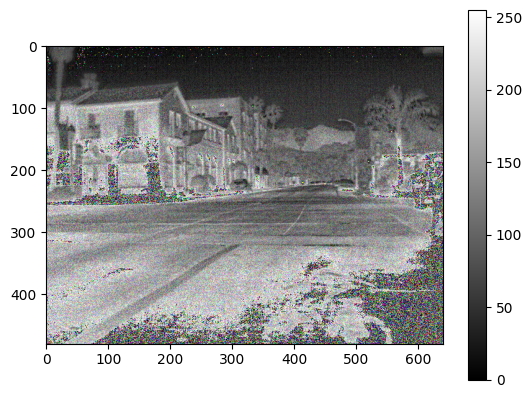

In [21]:
#folder = r"C:\Users\WillQuantique\OneDrive - univ-lyon2.fr\Fac\M1\DataChallege\archive\FLIR_ADAS_1_3\val\thermal_8_bit"

folder = r"C:\Users\WillQuantique\OneDrive - univ-lyon2.fr\Fac\M1\DataChallege\archive\FLIR_ADAS_1_3\val\trial"
out_path = r"C:\Users\WillQuantique\OneDrive - univ-lyon2.fr\Fac\M1\DataChallege\MosaicDataset"
images = load_images_from_folder(folder, size=(640, 480))

mosaic_images = add_noise_and_modify(images[0])
plt.imshow(mosaic_images, cmap='gray')
plt.colorbar()

plt.show()

In [ ]:
def build_generator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Decoder
    x = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(x)

    return Model(inputs, x)

generator = build_generator()
generator.summary()


In [ ]:
def build_discriminator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs, x)

discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()


In [ ]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(256, 256, 3))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    
    return Model(gan_input, gan_output)

gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')
gan.summary()


In [ ]:
# Assuming you have already created the mosaic and good images datasets
good_images_folder = 'dataset/good_images'
mosaic_images_folder = 'dataset/mosaic_images'

# Load the images into arrays
good_images = load_images_from_folder(good_images_folder)
mosaic_images = load_images_from_folder(mosaic_images_folder)


In [ ]:
def train_gan(generator, discriminator, gan, mosaic_images, good_images, epochs=10000, batch_size=32):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, len(good_images), batch_size)
        real_imgs = np.array(good_images)[idx]
        mosaic_imgs = np.array(mosaic_images)[idx]
        
        gen_imgs = generator.predict(mosaic_imgs)
        
        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train Generator
        g_loss = gan.train_on_batch(mosaic_imgs, valid)
        
        # Print the progress
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")
        
        # If at save interval, save generated image samples
        if epoch % 1000 == 0:
            save_imgs(epoch, generator)

def save_imgs(epoch, generator, examples=3):
    r, c = examples, 2
    idx = np.random.randint(0, len(mosaic_images), examples)
    mosaic_imgs = np.array(mosaic_images)[idx]
    gen_imgs = generator.predict(mosaic_imgs)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        axs[i, 0].imshow(cv2.cvtColor(mosaic_imgs[i], cv2.COLOR_BGR2RGB))
        axs[i, 0].set_title("Mosaic")
        axs[i, 0].axis('off')
        axs[i, 1].imshow(cv2.cvtColor(gen_imgs[i], cv2.COLOR_BGR2RGB))
        axs[i, 1].set_title("Generated")
        axs[i, 1].axis('off')
    fig.savefig(f"images/{epoch}.png")
    plt.close()

# Start training the GAN
train_gan(generator, discriminator, gan, mosaic_images, good_images)
